# ARL Compare


In [1]:
from exp import *


In [2]:
# pip install --upgrade efficientnet-pytorch


## Load the dataset

In [2]:
dm = DatasetManager('2017',224,'all','2017')

In [3]:
def reload_dataset(dm,segmented=False, seed=1):
    random_seed(seed,True)
    tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.8, max_lighting=0.3,p_affine=1, max_warp=0)
    data = ImageList.from_folder(dm.get_dataset_path('train_images').parent)\
    .split_by_folder(train=dm.get_dataset_path('train_images').name + ('_segmented' if segmented else ''),
                   valid=dm.get_dataset_path('valid_images').name +('_segmented' if segmented else ''))\
    .label_from_func(dm.get_label_for_image_path)\
    .transform(tfms,size=128)\
    .databunch(bs=16)\
    .normalize(imagenet_stats)
    return data

data = reload_dataset(dm)

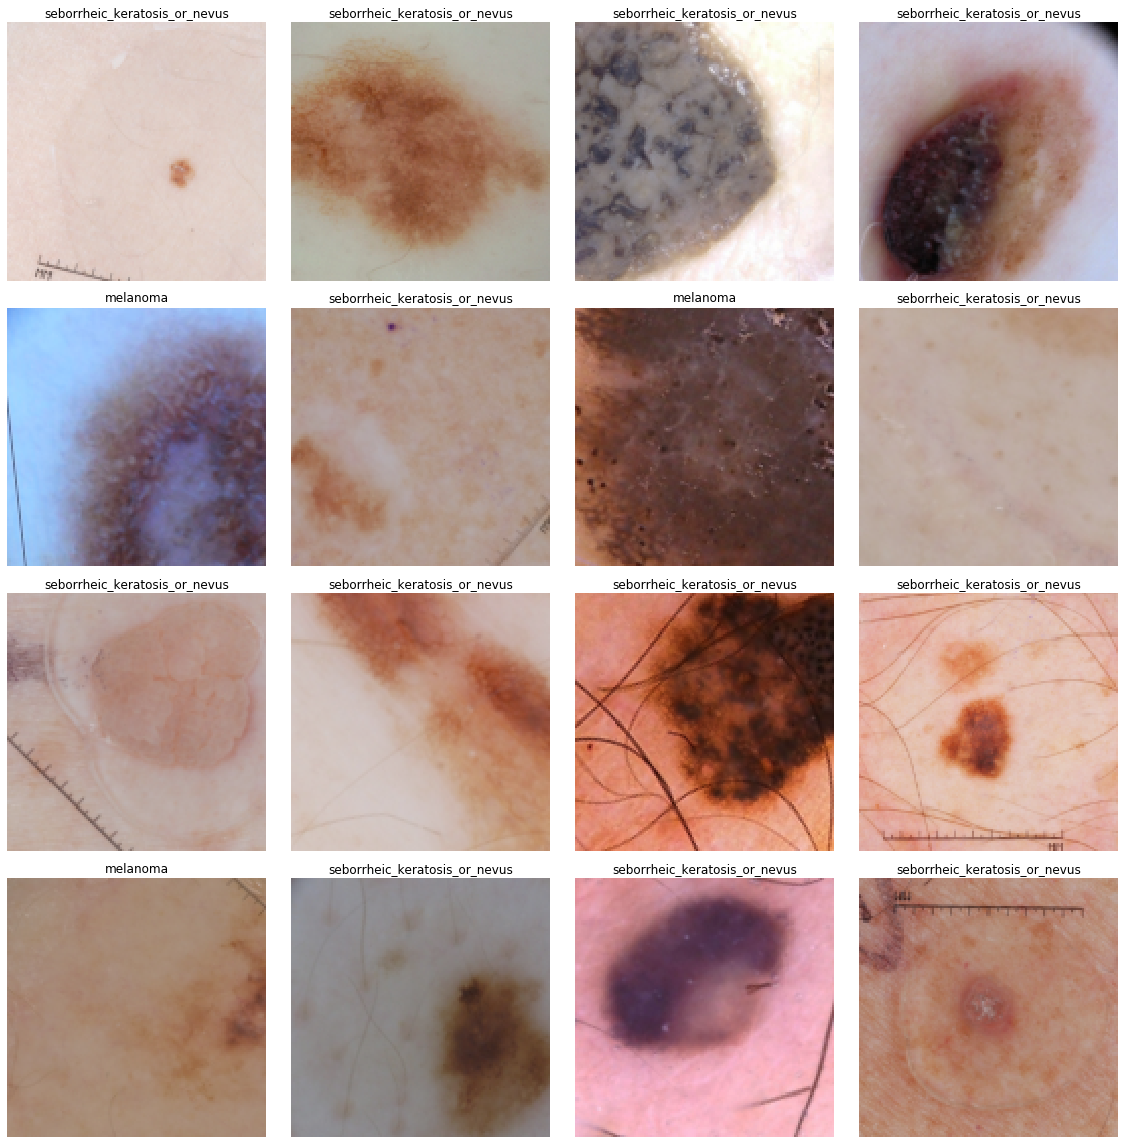

In [4]:
data.show_batch()

In [5]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print('train_count: \n',train_count,'\n\n','valid_count: \n', valid_count)
print('ratios:')
print(valid_count / train_count, '%')

train_count: 
 seborrheic_keratosis_or_nevus    1626
melanoma                          374
dtype: int64 

 valid_count: 
 seborrheic_keratosis_or_nevus    120
melanoma                          30
dtype: int64
ratios:
seborrheic_keratosis_or_nevus    0.073801
melanoma                         0.080214
dtype: float64 %


# Adding attention

In [6]:
from torchvision.models.resnet import Bottleneck
import types

In [29]:
alpha_initial_value = 0.0001
def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

            
        #identity N x C x H x W
        #alpha C
        #out N x C x H x W
        #out * identity * alpha = N x C x H x W
        
            
        out = out + (identity 
                     * self.softmaxLayer(out.view(*out.size()[:2], -1)).view_as(out) 
                     * self.alpha) + (identity)

        out = self.relu(out)
        return out

def add_attn_to_forward_func(a_module):
    a_module.forward = types.MethodType( forward,a_module)
    
def add_attn_params(a_module):
    a_module.softmaxLayer = nn.Softmax(2);
    a_module.alpha = nn.Parameter(torch.tensor(alpha_initial_value))
#     print(f'Added attention to {a_module}')
    
    
def change_basic_blocks(a_module):
    if not isinstance(a_module, Bottleneck): return
    add_attn_params(a_module)
    add_attn_to_forward_func(a_module)

In [35]:
ResNet50_with_attn = models.resnet50(pretrained=True)
apply_leaf(ResNet50_with_attn, change_basic_blocks)

In [36]:
bottlenecks = [bn for bn in ResNet50_with_attn.modules() if isinstance(bn,Bottleneck)]

class Alphas(ActivationStats):
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return m.alpha.item(),m.alpha.item()

In [32]:
for b in bottlenecks:
    assert b.alpha.requires_grad

## Create the learners

In [39]:
learn_baseline = cnn_learner(data, models.resnet50, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[ShowGraph, partial(Alphas, modules=bottlenecks) ], pretrained=True)

In [41]:
learn_baseline.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     False     
___________________________________________________

In [37]:
learn_attn = cnn_learner(data, lambda x: ResNet50_with_attn, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[ShowGraph, partial(Alphas, modules=bottlenecks) ], pretrained=True)

In [46]:
learn_attn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     False     
___________________________________________________

In [49]:
ps = list(learn_attn.model.named_parameters())

ls = [n for n in ps if 'alpha' in n[0]]

assert len(ls) == 16

ps = list(learn_baseline.model.named_parameters())

ls = [n for n in ps if 'alpha' in n[0]]

assert len(ls) == 0

# Train Learn attn and visualize alphas

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.088905,0.795309,0.273333,0.726667,0.651944,00:14
1,0.604926,0.581524,0.200000,0.800000,0.719167,00:11
2,0.517539,0.472693,0.186667,0.813333,0.737222,00:12
3,0.452073,0.446274,0.186667,0.813333,0.766945,00:11


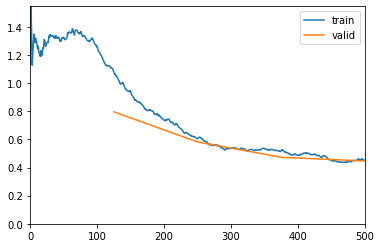

In [55]:
learn_attn.fit_one_cycle(4,max_lr=slice(3e-3))


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.408664,0.429779,0.193333,0.806667,0.770555,00:20
1,0.414325,0.442341,0.180000,0.820000,0.780278,00:26
2,0.433200,0.426555,0.200000,0.800000,0.789722,00:22
3,0.421079,0.406423,0.166667,0.833333,0.815000,00:20
4,0.414498,0.438477,0.180000,0.820000,0.778055,00:20
5,0.412213,0.420833,0.173333,0.826667,0.818056,00:20
6,0.395664,0.401837,0.160000,0.840000,0.830556,00:20
7,0.387385,0.419794,0.140000,0.860000,0.803056,00:21
8,0.367036,0.433526,0.200000,0.800000,0.794444,00:21
9,0.376796,0.443332,0.173333,0.826667,0.793333,00:21


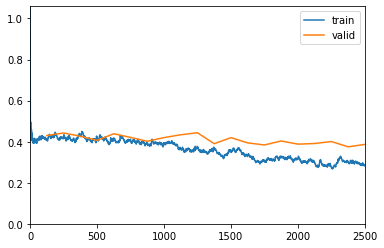

In [57]:
learn_attn.unfreeze()
learn_attn.fit_one_cycle(20,max_lr=slice(3e-4))


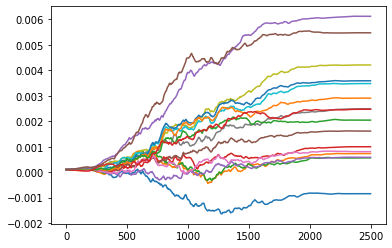

In [58]:
for i in range(len(learn_attn.alphas.stats[0])):
    plt.plot(learn_attn.alphas.stats[0][i])

## Training

In [59]:
def train_model_and_return_metrics(data,model,seed,epochs):
    random_seed(seed,True)
    learner = cnn_learner(data, model, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph], 
                        pretrained=True)
    
        
    random_seed(seed,True)
    learner.fit_one_cycle(4,max_lr=slice(3e-3))
    accuracies = list(map(lambda x: x[1], learner.recorder.metrics))
    
    #Unfreeze
    learner.unfreeze()
    random_seed(seed,True)
    learner.fit_one_cycle(epochs, max_lr=slice(3e-4))
    
    accuracies += list(map(lambda x: x[1], learner.recorder.metrics))


    return accuracies

# Comparison Various seeds

In [63]:
results_file_name = 'resnet_50_arl_seed'
columns = ['Baseline','ARL']

In [64]:
def write_results(seed,*args):
    f = open(f'{results_file_name}_{seed}.txt','w+')
    f.write(','.join(columns) + '\n')
    
    for epoch in zip(*args):
        line = ''
        for idx, variant in enumerate(epoch):
            line += str(variant.item())
            if idx != (len(epoch) - 1): 
                line += ','
            else: 
                line += '\n'
        
        f.write(line)


    f.close()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.044412,0.830393,0.286667,0.713333,0.647222,00:08
1,0.622678,0.636185,0.240000,0.760000,0.626389,00:08
2,0.504328,0.509433,0.206667,0.793333,0.708333,00:08
3,0.450122,0.448864,0.180000,0.820000,0.760556,00:08


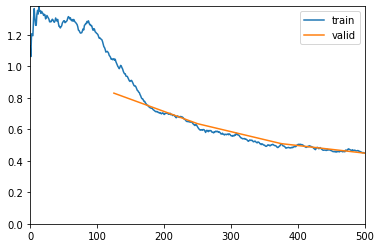

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.237122,0.429354,0.173333,0.826667,0.781944,00:15
1,0.149821,0.431877,0.173333,0.826667,0.819722,00:14
2,0.092572,0.541064,0.193333,0.806667,0.729444,00:15
3,0.375184,0.420027,0.173333,0.826667,0.823055,00:15
4,0.413758,0.468402,0.206667,0.793333,0.753056,00:14
5,0.407291,0.470634,0.180000,0.820000,0.726667,00:15
6,0.417381,0.460855,0.160000,0.840000,0.738056,00:15
7,0.400644,0.458611,0.180000,0.820000,0.773056,00:15
8,0.395670,0.475844,0.200000,0.800000,0.782222,00:15
9,0.390512,0.428494,0.186667,0.813333,0.802222,00:16


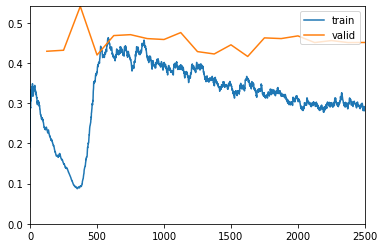

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.042848,0.826078,0.280000,0.720000,0.652500,00:10
1,0.631391,0.643097,0.240000,0.760000,0.621667,00:12
2,0.508749,0.498503,0.193333,0.806667,0.729167,00:13
3,0.450744,0.435914,0.173333,0.826667,0.779444,00:12


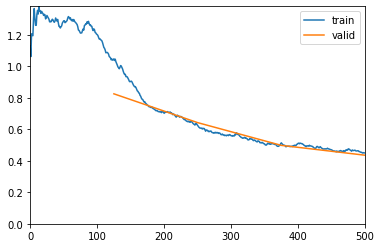

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.238096,0.418163,0.173333,0.826667,0.792778,00:20
1,0.150215,0.422432,0.166667,0.833333,0.828056,00:19
2,0.094634,0.492799,0.186667,0.813333,0.773333,00:18
3,0.382318,0.451225,0.193333,0.806667,0.824722,00:19
4,0.425137,0.442104,0.206667,0.793333,0.798889,00:19
5,0.406669,0.449834,0.166667,0.833333,0.756111,00:18
6,0.407077,0.393937,0.173333,0.826667,0.813611,00:18
7,0.399479,0.440180,0.166667,0.833333,0.783611,00:19
8,0.397630,0.444543,0.220000,0.780000,0.800000,00:19
9,0.370133,0.478408,0.186667,0.813333,0.774722,00:19


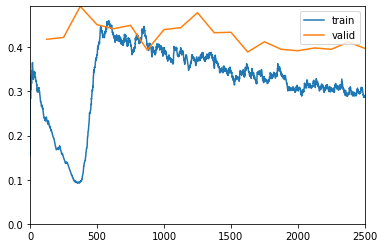

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.007910,0.659601,0.253333,0.746667,0.698333,00:08
1,0.611981,0.594641,0.200000,0.800000,0.667500,00:08
2,0.508462,0.467072,0.200000,0.800000,0.783889,00:08
3,0.458841,0.467667,0.206667,0.793333,0.762222,00:08


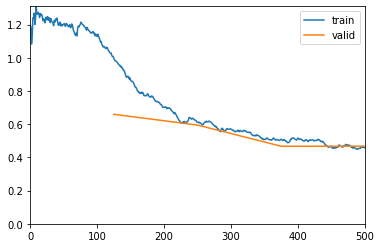

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.236167,0.451260,0.193333,0.806667,0.789444,00:15
1,0.145884,0.467190,0.200000,0.800000,0.805556,00:14
2,0.106594,0.526312,0.186667,0.813333,0.795000,00:15
3,0.382049,0.452608,0.186667,0.813333,0.789167,00:15
4,0.443922,0.444343,0.173333,0.826667,0.804444,00:15
5,0.418304,0.448749,0.166667,0.833333,0.793333,00:18
6,0.407102,0.479563,0.173333,0.826667,0.740278,00:18
7,0.399605,0.436786,0.173333,0.826667,0.818333,00:15
8,0.405470,0.416268,0.146667,0.853333,0.818333,00:14
9,0.380948,0.408107,0.180000,0.820000,0.853056,00:15


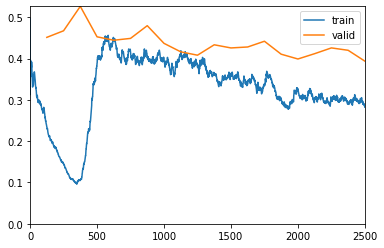

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.004429,0.661608,0.260000,0.740000,0.701667,00:10
1,0.627661,0.540798,0.206667,0.793333,0.703056,00:10
2,0.499810,0.450170,0.200000,0.800000,0.795556,00:10
3,0.452445,0.441628,0.193333,0.806667,0.783611,00:10


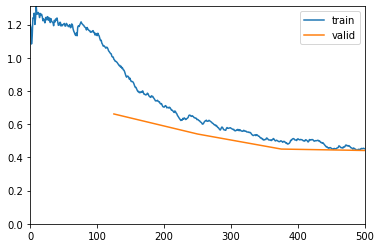

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.239953,0.436282,0.193333,0.806667,0.804722,00:19
1,0.151302,0.457747,0.193333,0.806667,0.813611,00:19
2,0.106917,0.495888,0.180000,0.820000,0.816667,00:18
3,0.379306,0.428105,0.173333,0.826667,0.798611,00:18
4,0.436017,0.393300,0.173333,0.826667,0.849445,00:23
5,0.421348,0.426086,0.166667,0.833333,0.807778,00:23
6,0.408963,0.435855,0.186667,0.813333,0.798333,00:19
7,0.400384,0.457101,0.180000,0.820000,0.794722,00:18
8,0.404727,0.425377,0.166667,0.833333,0.791667,00:19
9,0.387663,0.376830,0.173333,0.826667,0.856389,00:19


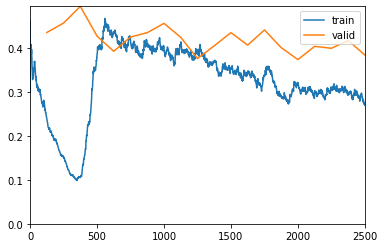

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.953249,0.784257,0.226667,0.773333,0.613056,00:08
1,0.606536,0.584935,0.206667,0.793333,0.655556,00:08
2,0.486376,0.500584,0.193333,0.806667,0.728611,00:08
3,0.468105,0.507174,0.193333,0.806667,0.720556,00:08


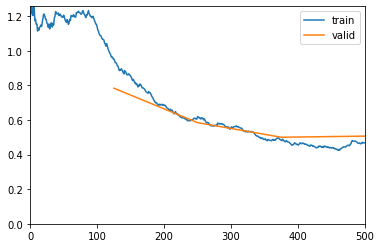

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.241815,0.492989,0.200000,0.800000,0.738333,00:14
1,0.140355,0.497548,0.180000,0.820000,0.750278,00:14
2,0.077119,0.535290,0.200000,0.800000,0.723611,00:15
3,0.406293,0.566868,0.193333,0.806667,0.707778,00:14
4,0.412052,0.514824,0.186667,0.813333,0.743333,00:15
5,0.407586,0.494943,0.186667,0.813333,0.763611,00:14
6,0.408039,0.400915,0.180000,0.820000,0.867222,00:15
7,0.395688,0.405139,0.166667,0.833333,0.853333,00:15
8,0.385493,0.466771,0.173333,0.826667,0.814722,00:14
9,0.386022,0.414320,0.160000,0.840000,0.841667,00:15


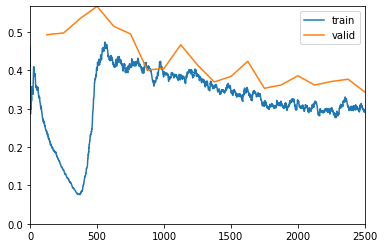

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.952862,0.780502,0.233333,0.766667,0.611944,00:10
1,0.616688,0.569843,0.193333,0.806667,0.654445,00:10
2,0.485744,0.512551,0.200000,0.800000,0.716667,00:10
3,0.470950,0.509204,0.186667,0.813333,0.712778,00:10


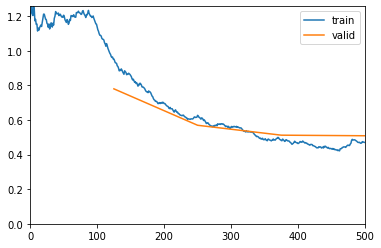

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.232808,0.491898,0.200000,0.800000,0.747778,00:22
1,0.131588,0.493129,0.186667,0.813333,0.756389,00:22
2,0.077210,0.536682,0.200000,0.800000,0.703889,00:19
3,0.407562,0.545103,0.200000,0.800000,0.731667,00:18
4,0.416794,0.528567,0.193333,0.806667,0.725000,00:19
5,0.400556,0.532595,0.180000,0.820000,0.742778,00:19
6,0.405103,0.468004,0.186667,0.813333,0.786945,00:19
7,0.401714,0.465993,0.186667,0.813333,0.808889,00:19
8,0.392663,0.472495,0.173333,0.826667,0.787778,00:18
9,0.372934,0.436190,0.153333,0.846667,0.832222,00:19


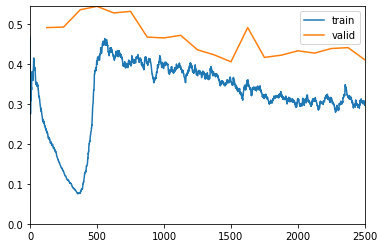

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.064922,0.731794,0.286667,0.713333,0.605556,00:10
1,0.620251,0.498030,0.200000,0.800000,0.719167,00:08
2,0.510009,0.465695,0.173333,0.826667,0.760833,00:08
3,0.472793,0.437512,0.173333,0.826667,0.796945,00:08


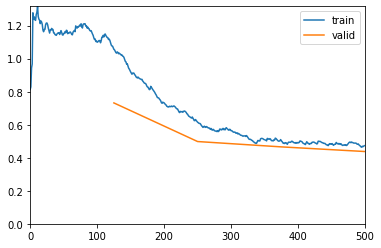

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.229319,0.426581,0.180000,0.820000,0.816111,00:15
1,0.161217,0.414831,0.186667,0.813333,0.817222,00:14
2,0.106314,0.484304,0.173333,0.826667,0.788889,00:15
3,0.404018,0.472820,0.180000,0.820000,0.800278,00:14
4,0.457399,0.396909,0.160000,0.840000,0.816944,00:15
5,0.423323,0.432276,0.173333,0.826667,0.802500,00:14
6,0.396376,0.468363,0.173333,0.826667,0.790000,00:14
7,0.398820,0.413550,0.173333,0.826667,0.825000,00:17
8,0.366778,0.448055,0.200000,0.800000,0.807500,00:17
9,0.349759,0.454353,0.193333,0.806667,0.777778,00:16


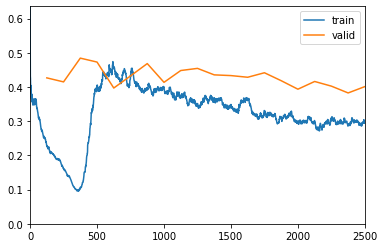

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.065772,0.736265,0.286667,0.713333,0.611944,00:10
1,0.621496,0.520969,0.200000,0.800000,0.713333,00:10
2,0.506893,0.469314,0.180000,0.820000,0.761667,00:10
3,0.476993,0.447326,0.166667,0.833333,0.785000,00:10


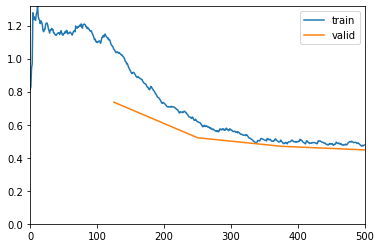

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.227273,0.435082,0.166667,0.833333,0.810833,00:19
1,0.158562,0.424315,0.180000,0.820000,0.803333,00:19
2,0.102349,0.509956,0.180000,0.820000,0.770556,00:19
3,0.405596,0.477009,0.160000,0.840000,0.784167,00:19
4,0.446808,0.455592,0.173333,0.826667,0.755556,00:19
5,0.431769,0.422739,0.166667,0.833333,0.793333,00:19
6,0.395631,0.473158,0.180000,0.820000,0.763611,00:18
7,0.385764,0.392482,0.173333,0.826667,0.851111,00:23
8,0.388703,0.404030,0.166667,0.833333,0.840833,00:20
9,0.356525,0.441570,0.160000,0.840000,0.793889,00:19


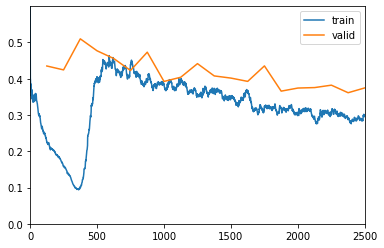

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.032312,0.715907,0.253333,0.746667,0.677778,00:09
1,0.659065,0.363765,0.146667,0.853333,0.835278,00:08
2,0.510779,0.449854,0.193333,0.806667,0.750278,00:08
3,0.444052,0.440141,0.180000,0.820000,0.778333,00:08


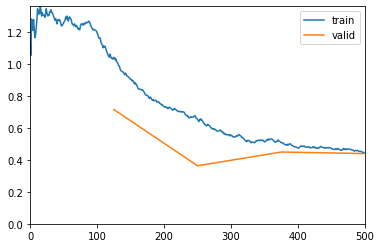

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.232344,0.452828,0.186667,0.813333,0.777222,00:14
1,0.149203,0.454650,0.180000,0.820000,0.787500,00:15
2,0.102961,0.482575,0.193333,0.806667,0.773611,00:15
3,0.365461,0.520054,0.193333,0.806667,0.745278,00:14
4,0.428523,0.466193,0.173333,0.826667,0.789167,00:15
5,0.427064,0.482709,0.213333,0.786667,0.765000,00:14
6,0.409917,0.428775,0.193333,0.806667,0.789445,00:14
7,0.389892,0.433554,0.193333,0.806667,0.803889,00:15
8,0.389266,0.441066,0.180000,0.820000,0.786111,00:15
9,0.371915,0.401352,0.153333,0.846667,0.803333,00:14


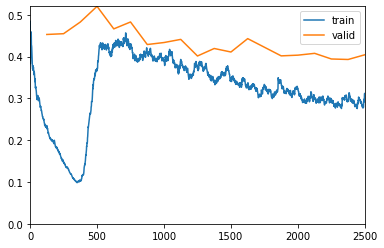

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.030241,0.698141,0.240000,0.760000,0.688056,00:10
1,0.652351,0.377805,0.140000,0.860000,0.825556,00:10
2,0.508917,0.448101,0.193333,0.806667,0.765556,00:10
3,0.446326,0.439644,0.166667,0.833333,0.785556,00:10


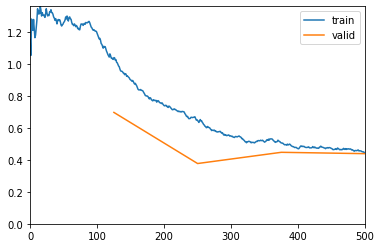

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.221825,0.454534,0.180000,0.820000,0.783333,00:19
1,0.142268,0.457115,0.180000,0.820000,0.793056,00:18
2,0.098461,0.475057,0.193333,0.806667,0.780555,00:23
3,0.377435,0.512466,0.186667,0.813333,0.742778,00:22
4,0.436302,0.493251,0.206667,0.793333,0.786111,00:19
5,0.436817,0.505381,0.200000,0.800000,0.748056,00:19
6,0.401570,0.441424,0.193333,0.806667,0.779722,00:19
7,0.400260,0.441693,0.173333,0.826667,0.781667,00:19
8,0.393254,0.386936,0.140000,0.860000,0.823889,00:18
9,0.363863,0.373464,0.166667,0.833333,0.852222,00:19


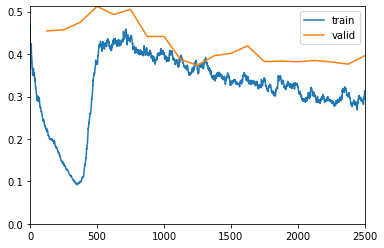

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.043752,0.935940,0.313333,0.686667,0.624444,00:08
1,0.611477,0.539567,0.186667,0.813333,0.684167,00:08
2,0.491039,0.471745,0.200000,0.800000,0.740833,00:08
3,0.441813,0.436885,0.173333,0.826667,0.760833,00:10


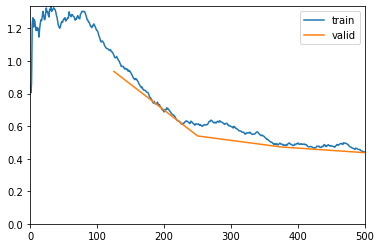

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.222924,0.438280,0.173333,0.826667,0.769167,00:18
1,0.138907,0.464916,0.206667,0.793333,0.752222,00:16
2,0.100572,0.469722,0.166667,0.833333,0.775556,00:15
3,0.379124,0.496054,0.173333,0.826667,0.756667,00:14
4,0.431874,0.454303,0.180000,0.820000,0.771111,00:14
5,0.428467,0.456379,0.173333,0.826667,0.757778,00:15
6,0.400328,0.434620,0.186667,0.813333,0.796111,00:14
7,0.392283,0.426221,0.186667,0.813333,0.796389,00:15
8,0.388035,0.406217,0.166667,0.833333,0.806667,00:14
9,0.375091,0.417364,0.166667,0.833333,0.809167,00:17


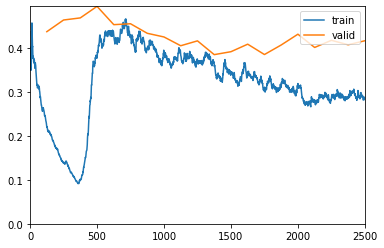

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.033882,0.947121,0.280000,0.720000,0.626667,00:10
1,0.616028,0.576980,0.200000,0.800000,0.658056,00:10
2,0.494196,0.488864,0.193333,0.806667,0.710833,00:10
3,0.447134,0.448945,0.193333,0.806667,0.743333,00:10


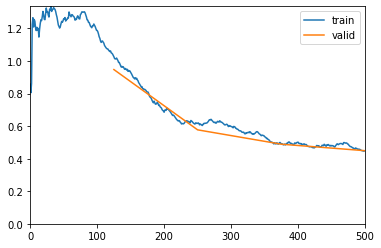

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.214953,0.449683,0.180000,0.820000,0.747222,00:19
1,0.143834,0.465215,0.186667,0.813333,0.744722,00:18
2,0.102411,0.495511,0.166667,0.833333,0.750556,00:18
3,0.390179,0.509207,0.193333,0.806667,0.744167,00:18
4,0.419549,0.446074,0.186667,0.813333,0.795278,00:19
5,0.435614,0.452178,0.186667,0.813333,0.768333,00:18
6,0.396485,0.459564,0.173333,0.826667,0.764167,00:18
7,0.396477,0.446519,0.193333,0.806667,0.766389,00:18
8,0.405018,0.426200,0.173333,0.826667,0.787778,00:19
9,0.378421,0.396050,0.173333,0.826667,0.818611,00:21


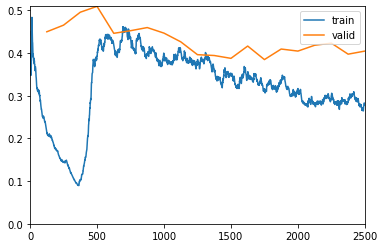

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.064029,0.843885,0.280000,0.720000,0.641944,00:08
1,0.630798,0.489918,0.220000,0.780000,0.740000,00:08
2,0.533675,0.452582,0.200000,0.800000,0.729167,00:08
3,0.464013,0.430991,0.186667,0.813333,0.778889,00:08


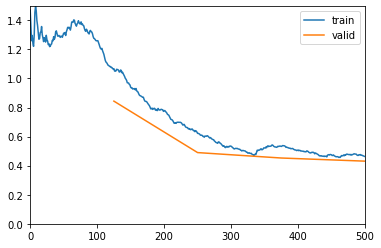

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.241735,0.429690,0.193333,0.806667,0.788889,00:14
1,0.153665,0.439123,0.166667,0.833333,0.773611,00:15
2,0.099685,0.477947,0.180000,0.820000,0.745278,00:15
3,0.397663,0.472311,0.193333,0.806667,0.779722,00:14
4,0.464394,0.433089,0.173333,0.826667,0.801111,00:15
5,0.429778,0.381142,0.166667,0.833333,0.831111,00:15
6,0.400445,0.416735,0.200000,0.800000,0.815833,00:15
7,0.390626,0.455563,0.200000,0.800000,0.796389,00:15
8,0.378720,0.449908,0.180000,0.820000,0.807778,00:14
9,0.358426,0.443249,0.186667,0.813333,0.821944,00:15


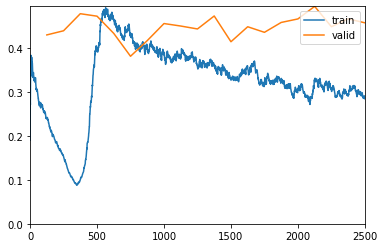

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.069517,0.822163,0.280000,0.720000,0.641667,00:12
1,0.638185,0.484143,0.193333,0.806667,0.740000,00:12
2,0.541277,0.466861,0.186667,0.813333,0.712778,00:10
3,0.464819,0.435419,0.193333,0.806667,0.773055,00:10


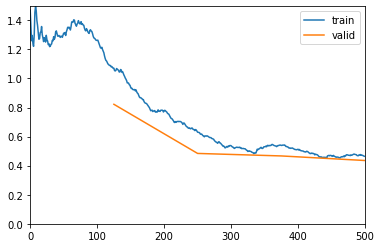

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.227909,0.434402,0.200000,0.800000,0.783611,00:19
1,0.149071,0.443143,0.180000,0.820000,0.775556,00:18
2,0.105035,0.500092,0.206667,0.793333,0.722222,00:18
3,0.404602,0.478484,0.206667,0.793333,0.775833,00:18
4,0.456248,0.417172,0.173333,0.826667,0.819444,00:23
5,0.414426,0.391894,0.153333,0.846667,0.821111,00:21
6,0.405817,0.459983,0.166667,0.833333,0.775278,00:19
7,0.406734,0.449021,0.173333,0.826667,0.805278,00:19
8,0.385770,0.440981,0.186667,0.813333,0.817222,00:19
9,0.354965,0.422453,0.186667,0.813333,0.830000,00:19


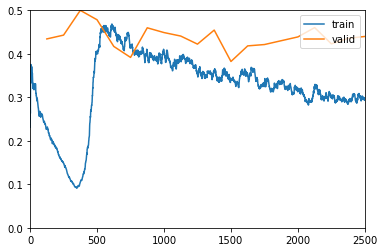

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.058809,0.683646,0.266667,0.733333,0.624167,00:08
1,0.669572,0.447691,0.206667,0.793333,0.746945,00:08
2,0.500082,0.452264,0.180000,0.820000,0.745833,00:08
3,0.444542,0.433796,0.180000,0.820000,0.777778,00:08


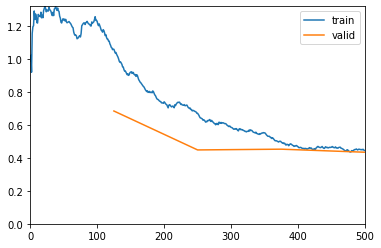

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.260958,0.464609,0.180000,0.820000,0.769445,00:15
1,0.158090,0.451030,0.166667,0.833333,0.773889,00:14
2,0.093505,0.452057,0.180000,0.820000,0.773333,00:14
3,0.365917,0.487413,0.173333,0.826667,0.774167,00:17
4,0.461802,0.505867,0.180000,0.820000,0.743056,00:18
5,0.438874,0.483754,0.186667,0.813333,0.764445,00:17
6,0.396540,0.477531,0.180000,0.820000,0.752500,00:15
7,0.402052,0.431047,0.180000,0.820000,0.831944,00:14
8,0.391194,0.443200,0.160000,0.840000,0.804444,00:15
9,0.373483,0.406826,0.180000,0.820000,0.809722,00:15


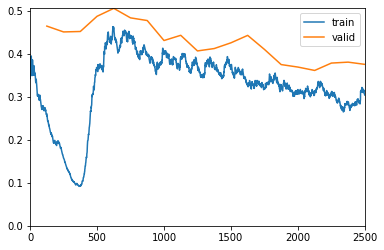

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.060401,0.685514,0.293333,0.706667,0.613333,00:10
1,0.662502,0.473889,0.200000,0.800000,0.733889,00:10
2,0.504564,0.463825,0.166667,0.833333,0.735278,00:10
3,0.444004,0.445402,0.166667,0.833333,0.770000,00:10


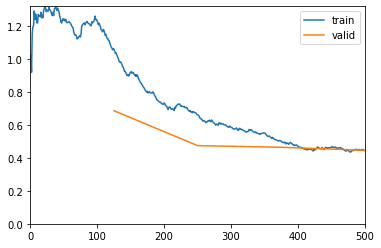

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.252230,0.471226,0.186667,0.813333,0.768056,00:18
1,0.144694,0.457490,0.166667,0.833333,0.765556,00:18
2,0.092070,0.461483,0.153333,0.846667,0.768611,00:18
3,0.360235,0.455614,0.160000,0.840000,0.799444,00:19
4,0.452776,0.490909,0.186667,0.813333,0.769306,00:19
5,0.443716,0.473566,0.166667,0.833333,0.758056,00:18
6,0.404989,0.447700,0.200000,0.800000,0.775000,00:19
7,0.409812,0.419567,0.206667,0.793333,0.827778,00:19
8,0.383849,0.431894,0.193333,0.806667,0.803889,00:19
9,0.368379,0.415844,0.166667,0.833333,0.816667,00:19


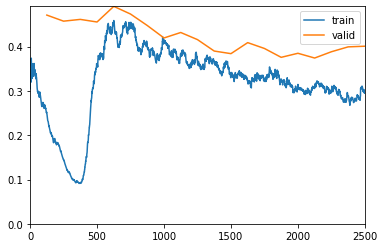

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.000610,0.634456,0.220000,0.780000,0.762222,00:08
1,0.637334,0.479458,0.246667,0.753333,0.763611,00:08
2,0.489863,0.491800,0.180000,0.820000,0.745555,00:08
3,0.465331,0.463053,0.166667,0.833333,0.757222,00:08


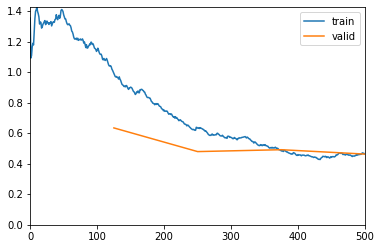

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.224049,0.448588,0.160000,0.840000,0.770833,00:15
1,0.136190,0.460828,0.193333,0.806667,0.779167,00:15
2,0.092521,0.524307,0.180000,0.820000,0.760278,00:14
3,0.403528,0.543039,0.180000,0.820000,0.719444,00:14
4,0.435766,0.454301,0.153333,0.846667,0.751389,00:15
5,0.434756,0.449723,0.173333,0.826667,0.795556,00:15
6,0.399476,0.468086,0.173333,0.826667,0.770000,00:15
7,0.386327,0.432765,0.180000,0.820000,0.792778,00:14
8,0.398252,0.455329,0.200000,0.800000,0.812222,00:14
9,0.362090,0.435842,0.166667,0.833333,0.811111,00:15


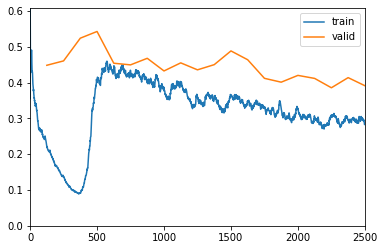

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.006496,0.644980,0.233333,0.766667,0.754167,00:10
1,0.642488,0.498798,0.213333,0.786667,0.748333,00:10
2,0.493421,0.464861,0.180000,0.820000,0.771111,00:09
3,0.462757,0.446132,0.166667,0.833333,0.770278,00:12


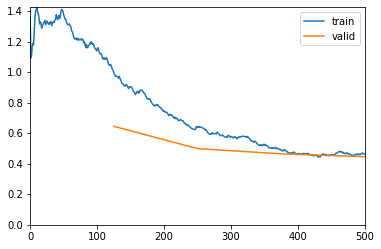

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.226199,0.432051,0.160000,0.840000,0.786944,00:23
1,0.141635,0.434186,0.180000,0.820000,0.798611,00:19
2,0.093579,0.499745,0.166667,0.833333,0.781945,00:19
3,0.391889,0.522072,0.180000,0.820000,0.743889,00:19
4,0.424440,0.492937,0.173333,0.826667,0.732778,00:18
5,0.455139,0.471761,0.153333,0.846667,0.759167,00:23
6,0.420529,0.498141,0.180000,0.820000,0.720555,00:21
7,0.399439,0.441310,0.180000,0.820000,0.766111,00:19
8,0.390350,0.410597,0.173333,0.826667,0.802778,00:19
9,0.371667,0.411265,0.173333,0.826667,0.832500,00:19


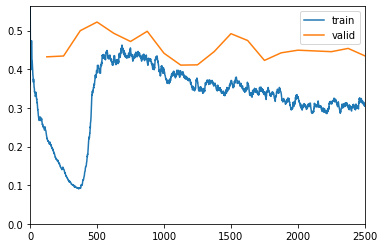

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.028375,0.667477,0.226667,0.773333,0.723889,00:08
1,0.639428,0.452955,0.186667,0.813333,0.756111,00:08
2,0.505872,0.478047,0.186667,0.813333,0.749722,00:08
3,0.448853,0.445873,0.173333,0.826667,0.770556,00:08


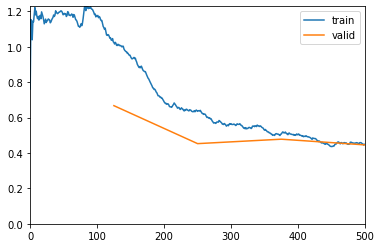

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.228880,0.451356,0.160000,0.840000,0.755833,00:15
1,0.143732,0.426363,0.153333,0.846667,0.807778,00:15
2,0.098576,0.488892,0.173333,0.826667,0.788333,00:14
3,0.378353,0.424331,0.166667,0.833333,0.844167,00:15
4,0.391143,0.473793,0.186667,0.813333,0.829444,00:15
5,0.397858,0.367779,0.160000,0.840000,0.873889,00:14
6,0.416014,0.461011,0.200000,0.800000,0.775555,00:18
7,0.398757,0.393123,0.146667,0.853333,0.816389,00:18
8,0.385667,0.388627,0.186667,0.813333,0.865278,00:14
9,0.398089,0.374157,0.140000,0.860000,0.851945,00:14


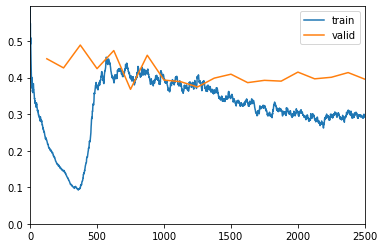

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.025341,0.708921,0.240000,0.760000,0.710555,00:10
1,0.640467,0.493604,0.193333,0.806667,0.728889,00:10
2,0.513846,0.475211,0.173333,0.826667,0.754722,00:10
3,0.457016,0.437089,0.160000,0.840000,0.778055,00:10


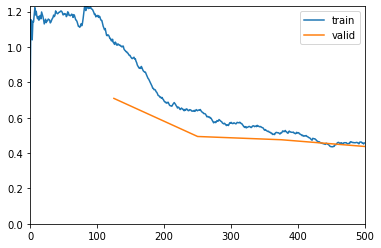

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.228365,0.447479,0.160000,0.840000,0.757500,00:19
1,0.153414,0.422339,0.153333,0.846667,0.798333,00:19
2,0.104420,0.475692,0.166667,0.833333,0.792500,00:19
3,0.374256,0.453252,0.180000,0.820000,0.824722,00:19
4,0.399058,0.461416,0.180000,0.820000,0.832500,00:19
5,0.386742,0.400015,0.160000,0.840000,0.834167,00:19
6,0.416575,0.436389,0.186667,0.813333,0.820556,00:19
7,0.386027,0.422510,0.180000,0.820000,0.798056,00:18
8,0.386514,0.428558,0.186667,0.813333,0.833333,00:18
9,0.399523,0.379153,0.186667,0.813333,0.853889,00:19


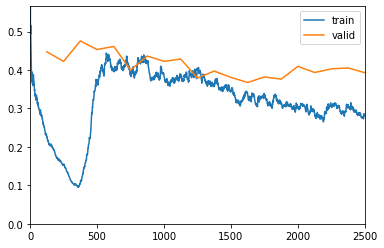

In [65]:
seeds = range(1,11)
epochs = 20

for seed in seeds:
    #Baseline
    data = reload_dataset(dm,seed=seed)    
    baseline_acc = train_model_and_return_metrics(data,models.resnet50, seed,epochs)
    
    #ARL
    data = reload_dataset(dm,seed=seed)
    
    ResNet50_with_attn = models.resnet50(pretrained=True)
    apply_leaf(ResNet50_with_attn, change_basic_blocks)
    
    arl_acc = train_model_and_return_metrics(data,lambda x: ResNet50_with_attn, seed,epochs)


    
    write_results(seed, baseline_acc, arl_acc)
    